In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap
from functools import reduce
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot, plot_training_history
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss, AE, decoder, create_meta_decoder_n

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters, concat_dims_one_hot, concat_dims

2025-02-27 15:13:43.803803: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 15:13:43.859968: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 15:13:44.278027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 15:13:44.280215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 15:13:45.724458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID

# GTM data
"""
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)
"""

'\nsize_chunck = 20_000\nmin_maf = 0.01\n\npath_raw = f"{CONFIG[\'PATH_data\']}/01_raw/geno.pkl"\npath_afs = f"{CONFIG[\'PATH_data\']}/02_usefull/allele_frequencies.pkl"\npath_output = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\n\ndivide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)\n'

# Choose SNPs to project on n dimensions

# Observe raw dimensions

In [3]:
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
ids = ids.merge(labels, left_on="IID", right_on="Sample name")

In [5]:
# taking the first PC of the SNP data then finding the snps which describe the most variance
# doing PCA of the residual snps and reiterating the process nr_of_projected_dimensions times
# when having our projected dims explained by groups of snps, we can cluster the individuals based on silhouette scores
# and then we can assign the individuals to the clusters and repeat the process iterations times

"""
path_macro_similar = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
iterations = 4

for iter in list(range(iterations)):
    iter += 2
    print(f"Running iteration {iter}")
    path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    
    if iter == 2:
        ids[f"cluster_{iter}"] = f"{0}"
        os.makedirs(f"{path_output}/pop_{0}", exist_ok=True)
        ids.to_pickle(f"{path_output}/pop_{0}/ids.pkl")
        
    else:
        pass
    
    cluster_to_add = []
    for sub_pop in ids[f"cluster_{iter}"].unique():
        path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/pop_{sub_pop}/"
        os.makedirs(path_output, exist_ok=True)
        temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]
        nr_of_projected_dimensions = 3
        geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)
        
        existing_dims = []   
        for PCs in [f for f in os.listdir(path_output) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_output}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
            existing_dims.append(dim)
        labels = silhouette_score_clusters(temp_ids, existing_dims, plot=False)
        for element in labels:
            cluster_to_add.append(f"{sub_pop}_{element}")
            
    ids[f"cluster_{iter+1}"] = cluster_to_add
    ids.to_pickle(f"{CONFIG['PATH_data']}/iteration_{iter}/ids.pkl")
    
    # Vizualization
    path_input = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        temp_ids = ids[ids[f"cluster_{iter}"] == pop]
        path_pop = f"{path_input}/pop_{pop}"
        for PCs in [f for f in os.listdir(path_pop) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_pop}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
        if len(list(temp_ids['Population name'].unique())) > 20:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Superpopulation name', f"iteration {iter} - pop {pop}", palette = 'rocket')
        else:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Population name', f"iteration {iter} - pop {pop}", palette = 'rocket')

"""

'\npath_macro_similar = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\niterations = 4\n\nfor iter in list(range(iterations)):\n    iter += 2\n    print(f"Running iteration {iter}")\n    path_output = f"{CONFIG[\'PATH_data\']}/iteration_{iter}/"\n    \n    if iter == 2:\n        ids[f"cluster_{iter}"] = f"{0}"\n        os.makedirs(f"{path_output}/pop_{0}", exist_ok=True)\n        ids.to_pickle(f"{path_output}/pop_{0}/ids.pkl")\n        \n    else:\n        pass\n    \n    cluster_to_add = []\n    for sub_pop in ids[f"cluster_{iter}"].unique():\n        path_output = f"{CONFIG[\'PATH_data\']}/iteration_{iter}/pop_{sub_pop}/"\n        os.makedirs(path_output, exist_ok=True)\n        temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]\n        nr_of_projected_dimensions = 3\n        geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)\n        \n        existing_dims = []   \n        for PCs in [f for f i

# Find the dims per snp

In [7]:

# Every dimensions is explained by certain snps, we want to know which snps are the most important for each dimension
"""
path_data = f"{CONFIG['PATH_data']}/"
iteration_files = [f for f in os.listdir(path_data) if f.startswith('iteration')]
snp_ids_dfs = []
for iteration in iteration_files:
    path_iteration = f"{path_data}/{iteration}/"
    for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"
        snp_ids = pd.read_pickle(path_snp_ids)
        snp_ids = snp_ids.drop(columns=['pval', 'betas', '-logp'])
        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids['dim'])
        snp_ids = snp_ids.drop(columns=['dim'])
        snp_ids = snp_ids.sort_index()  # Now sort
        snp_ids_dfs.append(snp_ids)
        
snp_ids = reduce(lambda left, right: pd.merge(left, right, on='snp_rs'), snp_ids_dfs)
snp_ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/post_iterations_snp_ids.pkl")
"""

'\npath_data = f"{CONFIG[\'PATH_data\']}/"\niteration_files = [f for f in os.listdir(path_data) if f.startswith(\'iteration\')]\nsnp_ids_dfs = []\nfor iteration in iteration_files:\n    path_iteration = f"{path_data}/{iteration}/"\n    for pop in [f for f in os.listdir(path_iteration) if f.startswith(\'pop\')]:\n        pop = pop.split(\'pop_\')[1]\n        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"\n        snp_ids = pd.read_pickle(path_snp_ids)\n        snp_ids = snp_ids.drop(columns=[\'pval\', \'betas\', \'-logp\'])\n        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids[\'dim\'])\n        snp_ids = snp_ids.drop(columns=[\'dim\'])\n        snp_ids = snp_ids.sort_index()  # Now sort\n        snp_ids_dfs.append(snp_ids)\n        \nsnp_ids = reduce(lambda left, right: pd.merge(left, right, on=\'snp_rs\'), snp_ids_dfs)\nsnp_ids.to_pickle(f"{CONFIG[\'PATH_data\']}/02_usefull/post_iterations_snp_ids.pkl")\n'

# Make autoencoder

In [6]:
# create one dimensional representation of the data

In [10]:
"""
path_data = f"{CONFIG['PATH_data']}/iteration_2/pop_0/"
pop = '0'
dims_df = concat_dims(path_data, 3, pop)

hidden = 2
epoch = 500
patience = 10
[autoencoder, bottleneck_model, history] = AE(dims_df, 1, dims_df.shape[1]*2, epoch, patience)

bottle = bottleneck_model(dims_df.to_numpy())
bottleneck_df = pd.DataFrame(bottle, columns=['PC1'])
path_data = f"{CONFIG['PATH_data']}/iteration_1/pop_0/"
os.makedirs(path_data, exist_ok=True)
bottleneck_df.to_pickle(f"{path_data}/PCs_dim_1.pkl")
ids = pd.read_pickle(f"{CONFIG['PATH_data']}/02_usefull/ids.pkl")
ids['center_dim'] = list(bottleneck_df['PC1'])
ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/ids_with_center_dim.pkl")
ids[f"cluster_1"] = pop
ids.to_pickle(f"{CONFIG['PATH_data']}/iteration_1/ids.pkl")

make_population_plot(ids, 'center_dim', 'center_dim', 'FID', f"show IDs", palette = 'rocket')
"""

'\npath_data = f"{CONFIG[\'PATH_data\']}/iteration_2/pop_0/"\npop = \'0\'\ndims_df = concat_dims(path_data, 3, pop)\n\nhidden = 2\nepoch = 500\npatience = 10\n[autoencoder, bottleneck_model, history] = AE(dims_df, 1, dims_df.shape[1]*2, epoch, patience)\n\nbottle = bottleneck_model(dims_df.to_numpy())\nbottleneck_df = pd.DataFrame(bottle, columns=[\'PC1\'])\npath_data = f"{CONFIG[\'PATH_data\']}/iteration_1/pop_0/"\nos.makedirs(path_data, exist_ok=True)\nbottleneck_df.to_pickle(f"{path_data}/PCs_dim_1.pkl")\nids = pd.read_pickle(f"{CONFIG[\'PATH_data\']}/02_usefull/ids.pkl")\nids[\'center_dim\'] = list(bottleneck_df[\'PC1\'])\nids.to_pickle(f"{CONFIG[\'PATH_data\']}/02_usefull/ids_with_center_dim.pkl")\nids[f"cluster_1"] = pop\nids.to_pickle(f"{CONFIG[\'PATH_data\']}/iteration_1/ids.pkl")\n\nmake_population_plot(ids, \'center_dim\', \'center_dim\', \'FID\', f"show IDs", palette = \'rocket\')\n'

# Use lower dimensional representation to create AF probabilities

In [11]:
# make for every dims a concatenated dataframe so we have a df with all the dims for every pop, sort of one hot encoded
"""
concat_dims_one_hot(CONFIG['PATH_data'], 3)
"""

"\nconcat_dims_one_hot(CONFIG['PATH_data'], 3)\n"

In [12]:

# create a meta decoder combining all the decoders

iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    path_iteration = f"{CONFIG['PATH_data']}/{iteration}"
    iteration_nr = int(iteration.split('_')[1])
    print(f"Running iteration {iteration_nr}")
    path_iteration = f"{CONFIG['PATH_data']}/{iteration}/"
    decoders = []
    
    for i in range(iteration_nr):
        i += 1
        if i == iteration_nr:
            pass
        else:
            dim1 = pd.read_pickle(f"{CONFIG['PATH_data']}/{iterations[i-1]}/concated_one_hot_dims.pkl")
            dim2 = pd.read_pickle(f"{CONFIG['PATH_data']}/{iterations[i]}/concated_one_hot_dims.pkl")
            decoder_temp, decoder_history =  decoder(dim1, dim2, 1, 100, 10)
            decoders.append(decoder_temp)
    if iteration_nr == 1:
        pass
    else:
        meta_iter = create_meta_decoder_n(decoders)
        
        
        # Ensure all layers are trainable (for fine-tuning)
        for layer in meta_iter.layers:
            layer.trainable = True
        # Compile the meta-decoder
        meta_iter.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        meta_iter.save(f"{path_iteration}/meta_decoder.keras")

Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4


In [13]:
from keras.callbacks import EarlyStopping

def create_one_hot_mafs(df, central, dim, to_keep, meta):
    # Create a minor allele frequency (MAF) mask
    db_minor = df.copy()
    db_minor = db_minor.applymap(lambda x: 1 if x == to_keep else 0)
    decoder_temp, decoder_history =  decoder(dim, db_minor, 1, 100, 10)
    chunk_decoder = create_meta_decoder_n([meta, decoder_temp])
    
    # Ensure all layers are trainable
    for layer in chunk_decoder.layers:
        layer.trainable = True

    # Compile the meta-decoder
    chunk_decoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    history = chunk_decoder.fit(
        central.to_numpy(), 
        db_minor.to_numpy(), 
        epochs=200, 
        validation_split=0.2, 
        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
        verbose=0)
    AFs = chunk_decoder.predict(central.to_numpy(), verbose = 0)
    AFs = pd.DataFrame(AFs, columns=df.columns)
    return AFs

In [ ]:


central_dim  = pd.read_pickle(f"{CONFIG['PATH_data']}/iteration_1/concated_one_hot_dims.pkl")
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations[1:]:
    iteration_nr = int(iteration.split('_')[1])
    
    if iteration_nr == 1:
        pass
    else:
        path_iteration = f"{CONFIG['PATH_data']}/{iteration}"
        meta_past_iter = load_model(f"{path_iteration}/meta_decoder.keras", compile=False)
        meta_past_iter.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

        print(f"Running iteration {iteration_nr}")
        

        dim = pd.read_pickle(f"{path_iteration}/concated_one_hot_dims.pkl")
        # train decoder iteration i with chunk
        chroms = [f for f in os.listdir(f"{CONFIG['PATH_data']}/03_macro_similar_AF") if f.startswith('chrom')]
        for chrom in chroms:
            path_chrom = f"{CONFIG['PATH_data']}/03_macro_similar_AF/{chrom}"
            path_output_chrom = f"{path_iteration}/04_macro_estimated_AF/{chrom}"
            os.makedirs(path_output_chrom, exist_ok=True)
            chunks = [f for f in os.listdir(path_chrom) if f.startswith('chunk')]
            for chunk in chunks[0:1]:
                path_chunk = f"{path_chrom}/{chunk}"
                chunk_df = pd.read_pickle(path_chunk)
                
                # Create a minor allele frequency (MAF) mask
                min_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, -1, meta_past_iter)
                path_min_maf = f"{path_output_chrom}/q2/"
                os.makedirs(path_min_maf, exist_ok=True)
                min_AFs.to_pickle(f"{path_min_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
                
                # Create a het allele frequency (MAF) mask
                het_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, 0, meta_past_iter)
                path_het_maf = f"{path_output_chrom}/2pq/"
                os.makedirs(path_het_maf, exist_ok=True)
                het_AFs.to_pickle(f"{path_het_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
                
                # Create a het allele frequency (MAF) mask
                maj_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, 1, meta_past_iter)
                path_maj_maf = f"{path_output_chrom}/p2/"
                os.makedirs(path_maj_maf, exist_ok=True)
                maj_AFs.to_pickle(f"{path_maj_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")

Running iteration 2


: 

In [16]:
min_AFs + het_AFs + maj_AFs

,rs3928804_T,rs6695244_A,rs12745158_G,rs3010023_A,rs703115_C,rs7516288_A,rs6704281_T,rs10888929_T,rs10801960_A,rs7547336_G,...,rs115175163_T,rs79431368_G,rs370241406_G,rs548922784_T,rs3845608_G,rs545827664_G,rs555927498_T,rs17116969_G,rs79770347_A,rs539946677_G
0,0.933559,0.968858,1.031766,0.978458,0.991822,1.043725,0.993648,1.002781,1.019414,1.044620,...,1.024894,0.985117,0.955066,0.942562,0.943158,0.976645,0.975388,0.991785,0.980754,0.990794
1,0.925251,0.963822,1.027936,0.983526,0.938450,0.964237,0.978236,0.993464,1.054475,1.010900,...,0.996145,0.983705,0.943212,0.922188,0.950699,0.999802,0.965075,0.956747,1.006185,0.989510
2,0.942883,0.971167,1.020243,0.991734,0.989595,1.042923,1.014238,1.008607,1.014506,1.035665,...,1.048509,0.987075,0.956708,0.937588,0.958270,0.991523,0.979530,0.973036,0.979518,0.979715
3,0.943152,0.970611,1.021889,0.991099,0.989169,1.043210,1.012799,1.007665,1.013710,1.036519,...,1.044604,0.984084,0.953963,0.936496,0.956327,0.989558,0.976463,0.972259,0.978620,0.976359
4,0.942826,0.971409,1.019759,0.992013,0.989737,1.042797,1.014773,1.008879,1.014798,1.035440,...,1.049821,0.988025,0.957679,0.938082,0.958892,0.992205,0.980575,0.973397,0.979846,0.980831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,1.100145,1.297047,1.128311,1.281327,1.054693,1.125366,1.282797,1.256547,1.341430,1.371240,...,1.245535,1.052786,0.980531,1.105908,0.990969,1.197789,1.085470,1.175911,1.183681,1.249085
2500,1.098244,1.293925,1.126820,1.278571,1.053081,1.123609,1.280078,1.254148,1.338419,1.368107,...,1.242838,1.050930,0.979331,1.103627,0.989639,1.195408,1.083584,1.173382,1.181246,1.246312
2501,1.090890,1.281871,1.121258,1.267960,1.046939,1.116928,1.269560,1.244946,1.326901,1.355999,...,1.232623,1.043968,0.974861,1.094907,0.984690,1.186248,1.076468,1.163751,1.171964,1.235740
2502,1.094823,1.288310,1.124212,1.273626,1.050221,1.120488,1.275183,1.249864,1.333059,1.362477,...,1.238064,1.047677,0.977226,1.099567,0.987320,1.191149,1.080258,1.168897,1.176924,1.241385


In [24]:
central_dim

,pop_0_PC1_dim_1
0,-0.403815
1,-0.698340
2,-0.379183
3,-0.383097
4,-0.377904
...,...
2499,-0.994228
2500,-0.993705
2501,-0.991673
2502,-0.992761


In [30]:
chrom

'chrom_1'

iteration_2


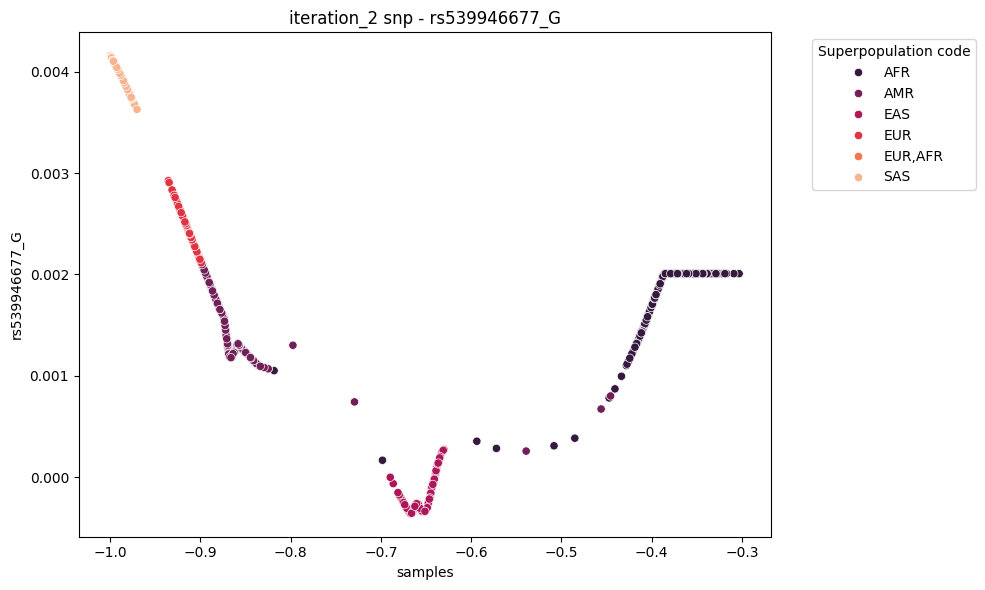

iteration_3


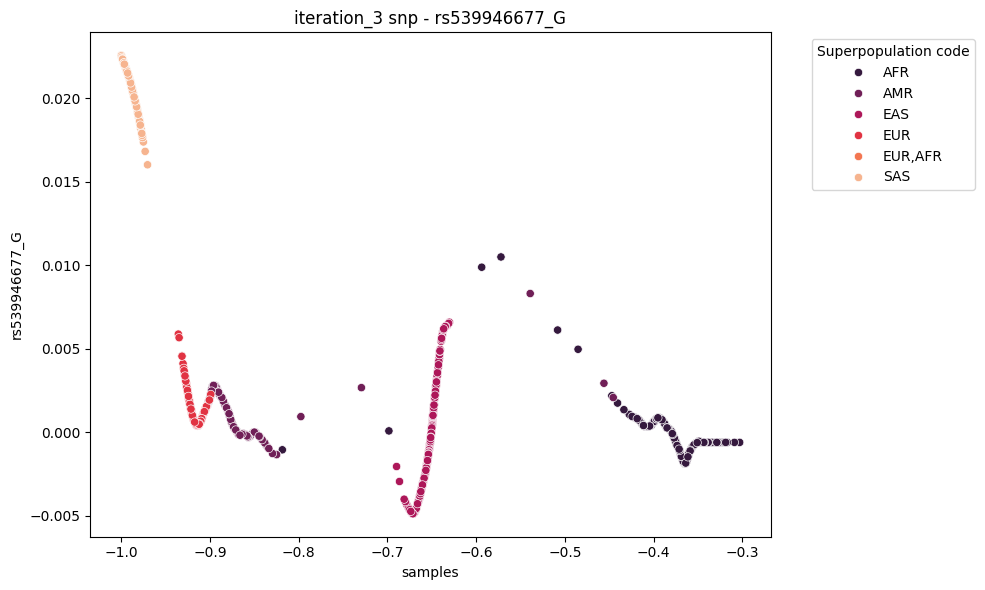

iteration_4


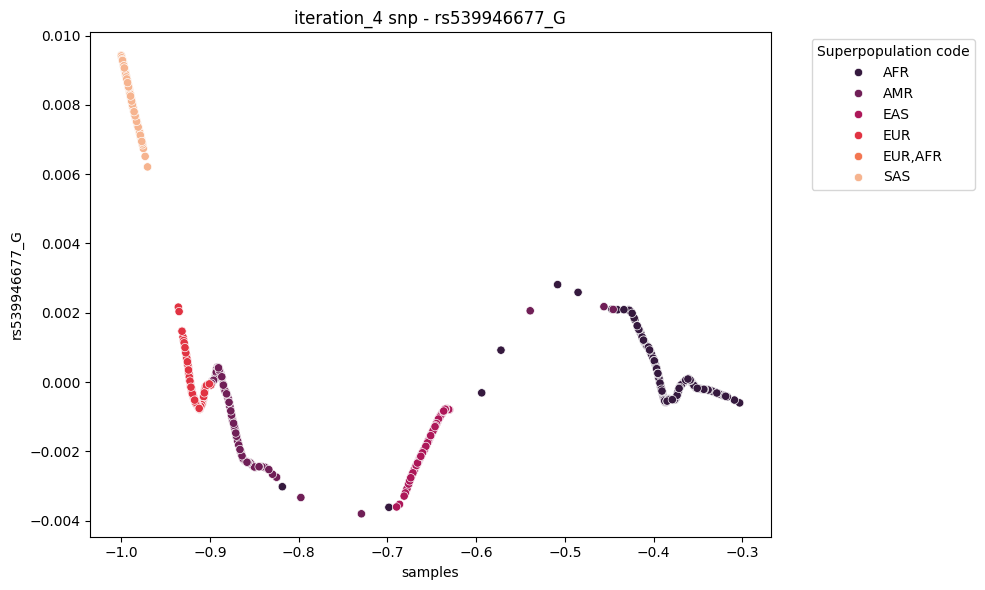

In [34]:
central_dim  = pd.read_pickle(f"{CONFIG['PATH_data']}/iteration_1/concated_one_hot_dims.pkl")
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations[1:]:
    print(iteration)
    path_maf = f"{CONFIG['PATH_data']}/{iteration}/04_macro_estimated_AF/"
    for chrom in [f for f in os.listdir(path_maf) if f.startswith('chrom')]:
        path_p2 = f"{path_maf}/{chrom}/p2/"
        chunks = [f for f in os.listdir(path_p2) if f.startswith('AFs')]
        path_chrom = f"{path_maf}/{chrom}/"
        for chunk in chunks:
            min_AFs = pd.read_pickle(f"{path_chrom}/q2/{chunk}")
            het_AFs = pd.read_pickle(f"{path_chrom}/2pq/{chunk}")
            maj_AFs = pd.read_pickle(f"{path_chrom}/p2/{chunk}")
            to_check = list(min_AFs.columns)[-1]
            AFs = min_AFs[[to_check]].copy()
            AFs['Superpopulation code'] = list(ids['Superpopulation code'])
            AFs['Population code'] = list(ids['Population code'])
            AFs['samples'] = list(central_dim['pop_0_PC1_dim_1'])
            make_population_plot(AFs, 'samples', to_check,'Superpopulation code', f"{iteration} snp - {to_check}", palette = 'rocket')
            
            #AFs = min_AFs + het_AFs + maj_AFs
            #AFs.to_pickle(f"{path_chunk}/AFs_{chunk.split('.pkl')[0]}.pkl")

In [28]:
make_population_plot(AFs, 'samples', to_check,'Superpopulation code', f"{iteration}", palette = 'rocket')


NameError: name 'AFs' is not defined

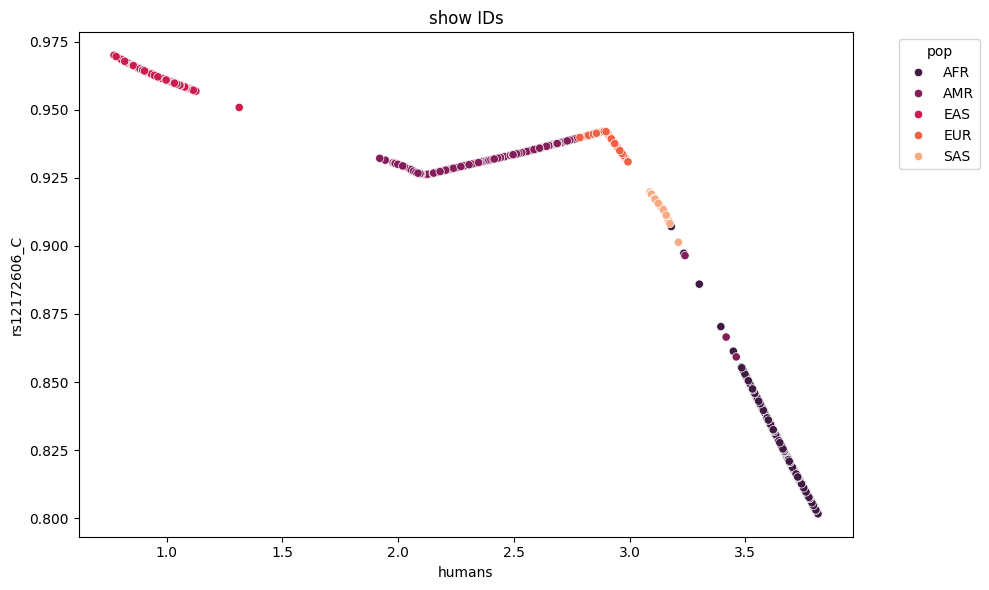

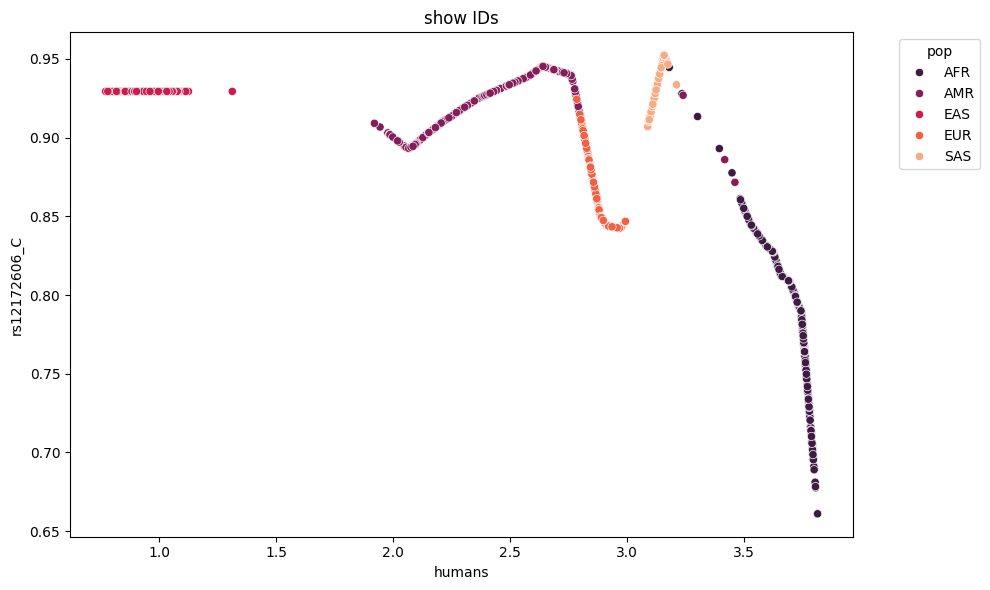

In [94]:
make_population_plot(test2, 'humans', col_test,'pop', f"show IDs", palette = 'rocket')


In [95]:
# Iteration 2

In [ ]:
path_data = f"{CONFIG['PATH_data']}/"
nr_it = 1
iteration = [f for f in os.listdir(path_data) if f.startswith(f"iteration_{nr_it}")][0]
path_iteration = f"{path_data}/{iteration}/"
ids = pd.read_pickle(f"{path_iteration}/ids.pkl")
dims_dfs = []
for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
    pop = pop.split('pop_')[1]
    temp_ids = ids[ids[f"cluster_{iteration.split('_')[1]}"] == pop]
    path_pop = f"{path_iteration}/pop_{pop}/"
    dims = [f for f in os.listdir(path_pop) if f.startswith('PCs')]
    
    nr_PCs = 3
    PCs_labels = []
    for i in range(nr_PCs):
        PCs_labels.append(f"PC{i+1}")

    dims_df = pd.DataFrame()
    for dim  in dims:
        path_dim = f"{path_pop}/{dim}"
        dim = dim.split('PCs_')[1].split('.pkl')[0]
        
        PCs = pd.read_pickle(path_dim)
        for label in PCs_labels:
            PCs.rename(columns={f"{label}": f"pop_{pop}_{label}_dim_{dim}"}, inplace=True)
            dims_df[f"pop_{pop}_{label}_dim_{dim}"] = list(PCs[f"pop_{pop}_{label}_dim_{dim}"])
    dims_df.index = temp_ids.index
    dims_dfs.append(dims_df)
        

# Concatenate DataFrames, filling missing columns with NaN
dims_dfs = pd.concat(dims_dfs, ignore_index=False, sort=True)
dims_dfs = dims_dfs.fillna(0)

In [ ]:

dims_dfs

,pop_0_0_PC1_dim_dim_1,pop_0_0_PC1_dim_dim_2,pop_0_0_PC1_dim_dim_3,pop_0_0_PC2_dim_dim_1,pop_0_0_PC2_dim_dim_2,pop_0_0_PC2_dim_dim_3,pop_0_0_PC3_dim_dim_1,pop_0_0_PC3_dim_dim_2,pop_0_0_PC3_dim_dim_3,pop_0_1_PC1_dim_dim_1,...,pop_0_3_PC3_dim_dim_3,pop_0_4_PC1_dim_dim_1,pop_0_4_PC1_dim_dim_2,pop_0_4_PC1_dim_dim_3,pop_0_4_PC2_dim_dim_1,pop_0_4_PC2_dim_dim_2,pop_0_4_PC2_dim_dim_3,pop_0_4_PC3_dim_dim_1,pop_0_4_PC3_dim_dim_2,pop_0_4_PC3_dim_dim_3
0,0.933013,-4.068720,10.336285,-3.492381,9.887428,-2.532068,9.639750,2.783962,7.823999,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.188379,-4.959371,16.235042,-2.123308,21.497266,3.080950,20.465567,0.438365,-1.994241,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.393187,-6.371439,-3.397163,-6.866763,-3.048944,6.415818,1.044204,2.575572,-2.637278,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.743959,-6.591337,7.333168,-6.852792,8.612897,-1.655533,8.877612,-0.498862,-0.818207,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.883044,-5.209089,2.450627,-4.378275,1.098689,2.820204,-2.990109,-2.853764,-3.851209,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.935759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.250069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.184803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.753146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
